In [4]:
# !python --version
# %pip install --upgrade pandas
# %pip install openpyxl
# %pip install numpy
# %pip install scikit-learn
# %pip install matplotlib
# %pip install plot_keras_history
# %pip install tensorflow
# %pip install keras-tuner

In [5]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
        print("Setting GPU Memory Growth...")
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time
import datetime

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plot_keras_history import plot_history
import sklearn.metrics as metrics
import os as os

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.python.client import device_lib
# import keras_tuner as kerastuner
# from keras_tuner.tuners import RandomSearch


print("TF version:", tf.__version__)
print("Panda version:", pd.__version__)

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print("Physical devices: ", tf.config.list_physical_devices())
# Se va a habilitar la dedicacion dinamica de memoria para que la GPU vaya asignando recursos al proceso conforme los vaya necesitando

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#print(tf.config.list_physical_devices('GPU'))
print("Build with CUDA: ", tf.test.is_built_with_cuda())

# Insantes de tiempo futuros a predecir
numPredictions = 20

# Porcentaje del conjunto de test
test_size = 0.3
# Porcentaje del conjunto de validacion
val_size = 0.3

# Establecer objetivo (Name of model metric to minimize or maximize, e.g. "val_accuracy"). 
# El "val_" hace referencia a que se coge la métrica en el subconjunto de validación

# obje = kerastuner.Objective('val_mean_absolute_percentage_error', 'min')

# Epocas
epchs = 1000
# Tamaño del batch
batch = 1024
# Nodos internos
hidden_nodes = 10

# Establecer medida de loss
loss = "mean_squared_error"
#loss = "mean_absolute_percentage_error"


SETTING MEMORY GROWTH
TF version: 2.1.0
Panda version: 1.1.5
Physical devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
Num GPUs Available:  1
Build with CUDA:  True


c:\Users\hecto\.conda\envs\myenv\lib\site-packages\tensorflow_core\python\client\session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [8]:
df = pd.read_excel("C:/Users/hecto/Documents/Master/TFM/tfm-renewable-energy-deep-learning/data/2015_30min.xlsx",
                    header = None, 
                    engine = 'openpyxl')[0]

# Data preprocessing: each row will contain the 20 measures for each day, 
# and the 20 measures for the following day
X = pd.DataFrame(np.array(df).reshape(-1, 20))
Y = pd.DataFrame.copy(X)

Y.columns = ["col_{}".format(i) for i in range(21, 41)]
Y = Y.drop(0)
Y = Y.reset_index(drop=True)
Y.loc[len(Y)] = np.zeros(numPredictions)

dfNoNormalized = pd.concat([X, Y], axis=1)

dataToPredict = dfNoNormalized.tail(1)
print("Row for predicting: ", dataToPredict)

print("DataFrame Preproccessed (Not Normalized):")
print(dfNoNormalized)
print("---------------------------------------------")

# Data Normalization
scaler = MinMaxScaler()
XNormalized = pd.DataFrame(scaler.fit_transform(X), 
                           columns = ["col_{}".format(i) for i in range(1, 21)])
YNormalized = pd.DataFrame(scaler.fit_transform(Y), 
                           columns = ["col_{}".format(i) for i in range(21, 41)])
dfPreproccessed = pd.concat([XNormalized, YNormalized], axis=1)

# Last row is deleted beacuse it is the one for used for the real prediction,
# it is not useful for the training of the model.
dfPreproccessed.drop(dfNoNormalized.tail(1).index, inplace=True)

print("Preprocessed Dataframe length: ", len(dfPreproccessed))

print("X Preproccessed:")
print(XNormalized)
print("---------------------------------------------")
print("Y Preproccessed:")
print(YNormalized)
print("---------------------------------------------")

# Split the data into training and validation sets
xTrain, xTest, yTrain, yTest = train_test_split(XNormalized, 
                                                YNormalized, 
                                                test_size = test_size, 
                                                random_state = 0, 
                                                shuffle=False)
xTrain, xVal, yTrain, yVal = train_test_split(xTrain, 
                                              yTrain, 
                                              test_size = val_size, 
                                              random_state = 0, 
                                              shuffle=False)

# Adding the third dimension needed to use LSTM (samples, timestamps, features)
xtrain = np.reshape(xTrain.values, (xTrain.shape[0], xTrain.shape[1], 1))
ytrain = np.reshape(yTrain.values, (yTrain.shape[0], yTrain.shape[1], 1))
xval = np.reshape(xVal.values, (xVal.shape[0], xVal.shape[1], 1))
yval = np.reshape(yVal.values, (yVal.shape[0], yVal.shape[1], 1))
xtest = np.reshape(xTest.values, (xTest.shape[0], xTest.shape[1], 1))
ytest = np.reshape(yTest.values, (yTest.shape[0], yTest.shape[1], 1))

# New shapes after third dimension added
print("Dimensions afther third dimension added:")
print("xTrain:\t"+str(xtrain.shape))
print("yTrain:\t"+str(ytrain.shape))
print("xVal:\t"+str(xval.shape))
print("yVal:\t"+str(yval.shape))
print("xTest:\t"+str(xtest.shape))
print("yTest:\t"+str(ytest.shape))

validation_data = xval.reshape((xval.shape[0], xval.shape[1]))

Row for predicting:                0           1           2           3           4        5  \
364  323.271333  320.158667  281.495667  465.665167  391.321167  609.922   

              6           7           8           9  ...  col_31  col_32  \
364  776.211667  696.617333  667.006833  663.280667  ...     0.0     0.0   

     col_33  col_34  col_35  col_36  col_37  col_38  col_39  col_40  
364     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[1 rows x 40 columns]
DataFrame Preproccessed (Not Normalized):
              0           1           2           3           4           5  \
0     96.691833  193.486833  700.986333  587.718333  454.512500  631.489833   
1    202.375667  166.977000  403.916667  340.241000  649.179667  708.682500   
2    109.810167  152.215167   84.124833  134.679500  183.520167  280.223333   
3    385.892667  406.789667  467.582500  380.776333  519.853833  493.757500   
4    278.043000  417.771833  342.662667  375.797833  460.997500  426.5515

In [9]:
with tf.device('/gpu:0'):    
# Model definition
    model = Sequential()
    model.add(LSTM(hidden_nodes, input_shape=(xtrain.shape[1], 1)))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(numPredictions, activation = "sigmoid"))

    print("Input shape", (xtrain.shape[1], 1))

    print("Summary: ")
    model.summary()

    # Model compilation
    model.compile(loss = loss,
                optimizer = "adam",
                metrics = [keras.metrics.MAE, 
                           keras.metrics.MAPE, 
                           keras.metrics.MSE])

    history = model.fit(
        xtrain.reshape((xtrain.shape[0], xtrain.shape[1], 1)),
        ytrain,
        epochs = epchs,
        batch_size = batch,
        validation_data = (xval.reshape((xval.shape[0], xval.shape[1], 1)), yval))
    

Input shape (20, 1)
Summary: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
Total params: 700
Trainable params: 700
Non-trainable params: 0
_________________________________________________________________
Train on 178 samples, validate on 77 samples
Epoch 1/1000
178/178 [==============================] - 1s 6ms/sample - loss: 0.0644 - mean_absolute_error: 0.2126 - mean_absolute_percentage_error: 426082.2812 - mean_squared_error: 0.0644 - val_loss: 0.0519 - val_mean_absolute_error: 0.1858 - val_mean_absolute_percentage_error: 161.5532 - val_mean_squared_er

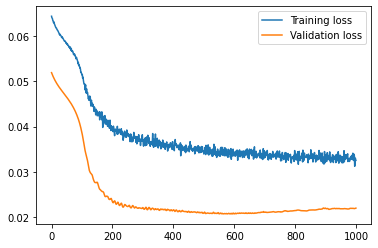

77/77 [==============================] - 0s 606us/sample - loss: 0.0220 - mean_absolute_error: 0.1150 - mean_absolute_percentage_error: 67.1725 - mean_squared_error: 0.0220
Score: [0.021998556016327497, 0.114953995, 67.1725, 0.021998556]


In [10]:
# Training and Validation loss curves
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

# Model evaluation with validation data
score = model.evaluate(xval.reshape((xval.shape[0], xval.shape[1], 1)), yval)
print('Score:', score)